<a href="https://colab.research.google.com/github/larasauser/master/blob/main/Whitt_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === 0) Installer / importer libs et monter Drive ===
!pip install rasterio tqdm scikit-image scikit-learn

import os
from glob import glob
from datetime import datetime
from tqdm import tqdm
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from scipy.linalg import lstsq
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 29.0 MB/s eta 0:00:00
Mounted at /content/drive


In [7]:
# === 1) Paramètres principaux ===
DRIVE_CLEAR_FOLDER = '/content/drive/MyDrive/Whitt/NDVI_grancy_Landsat8'
DRIVE_MASKED_FOLDER = '/content/drive/MyDrive/Whitt/NDVI_grancy_Landsat8_hole'
DRIVE_MODIS_FOLDER = '/content/drive/MyDrive/Whitt/NDVI_grancy_MODIS'
OUTPUT_FOLDER = '/content/drive/MyDrive/Whitt/egfwh_grancy_outputs'
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

WINDOW_METERS = 200.0
KAPPA = 1.0  # Whittaker smoothing
MIN_OVERLAP = 3

In [8]:
# === 2) Fonctions helpers ===
def parse_date_from_filename(fn):
    import re
    m = re.search(r'(\d{4})-(\d{2})-(\d{2})', os.path.basename(fn))
    if m:
        return datetime.strptime(''.join(m.groups()), '%Y%m%d').date()
    return datetime.fromtimestamp(os.path.getmtime(fn)).date()

def read_singleband_tif(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(np.float32)
        meta = src.meta.copy()
    nd = meta.get('nodata', None)
    if nd is not None:
        arr[arr==nd] = np.nan
    return arr, meta

def resample_to_target(src_arr, src_meta, target_meta):
    dst_arr = np.full((target_meta['height'], target_meta['width']), np.nan, dtype=np.float32)
    reproject(
        source=src_arr,
        destination=dst_arr,
        src_transform=src_meta['transform'],
        src_crs=src_meta['crs'],
        dst_transform=target_meta['transform'],
        dst_crs=target_meta['crs'],
        resampling=Resampling.bilinear
    )
    return dst_arr

In [9]:
# === 3) Charger et aligner les images ===
# trouver la plus petite image Landsat pour référence
clear_files = sorted(glob(os.path.join(DRIVE_CLEAR_FOLDER, '*.tif')))
masked_files = sorted(glob(os.path.join(DRIVE_MASKED_FOLDER, '*.tif')))
modis_files = sorted(glob(os.path.join(DRIVE_MODIS_FOLDER, '*.tif')))

sizes = []
for f in clear_files:
    arr, meta = read_singleband_tif(f)
    sizes.append((arr.shape[0]*arr.shape[1], f, arr.shape, meta))
sizes.sort()
_, ref_file, ref_shape, ref_meta = sizes[0]
H_ref, W_ref = ref_shape
PIXEL_SIZE_M = abs(ref_meta['transform'][0])
print("Reference Landsat:", os.path.basename(ref_file), "shape:", ref_shape)

# stacks Landsat
landsat_clear_stack, landsat_masked_stack = [], []
clear_dates, masked_dates = [], []

for f in clear_files:
    arr, meta = read_singleband_tif(f)
    if arr.shape != ref_shape:
        arr = resample_to_target(arr, meta, ref_meta)
    landsat_clear_stack.append(arr)
    clear_dates.append(parse_date_from_filename(f))

for f in masked_files:
    arr, meta = read_singleband_tif(f)
    if arr.shape != ref_shape:
        arr = resample_to_target(arr, meta, ref_meta)
    landsat_masked_stack.append(arr)
    masked_dates.append(parse_date_from_filename(f))

landsat_clear_stack = np.stack(landsat_clear_stack, axis=0)
landsat_masked_stack = np.stack(landsat_masked_stack, axis=0)
T, H, W = landsat_clear_stack.shape
print("Stacks shapes (clear/masked):", landsat_clear_stack.shape, landsat_masked_stack.shape)

# === MODIS local stack alignée sur dates Landsat ===
modis_stack = np.full((T, H, W), np.nan, dtype=np.float32)
modis_map = {parse_date_from_filename(f): f for f in modis_files}
modis_dates_list = sorted(modis_map.keys())

for ti, d in enumerate(clear_dates):  # ou common_dates
    diffs = [(abs((md - d).days), md) for md in modis_dates_list]
    nearest_md = min(diffs, key=lambda x: x[0])[1]
    mod_file = modis_map[nearest_md]
    arr, meta = read_singleband_tif(mod_file)
    arr_resampled = resample_to_target(arr, meta, ref_meta)
    modis_stack[ti] = arr_resampled

print("MODIS stack aligned:", modis_stack.shape)

Reference Landsat: NDVI_2013-06-05.tif shape: (344, 319)
Stacks shapes (clear/masked): (174, 344, 319) (6, 344, 319)
MODIS stack aligned: (174, 344, 319)


In [10]:
# === 4) Helpers EGF / Whittaker ===
def pearson_r(a, b):
    valid = ~np.isnan(a) & ~np.isnan(b)
    if valid.sum()<2: return np.nan
    x, y = a[valid], b[valid]
    xm, ym = x.mean(), y.mean()
    num = np.sum((x-xm)*(y-ym))
    den = np.sqrt(np.sum((x-xm)**2)*np.sum((y-ym)**2))
    if den==0: return np.nan
    return num/den

def compute_M_reference_pixel(i,j,modis_stack,sl_target_ts,radius_pix):
    T,H,W = modis_stack.shape
    i0, i1 = max(0,i-radius_pix), min(H,i+radius_pix+1)
    j0, j1 = max(0,j-radius_pix), min(W,j+radius_pix+1)
    coords = [(ii,jj) for ii in range(i0,i1) for jj in range(j0,j1)]
    corrs, mseries = [], []
    for ii,jj in coords:
        ms = modis_stack[:,ii,jj]
        r = pearson_r(ms, sl_target_ts)
        corrs.append(r); mseries.append(ms)
    corrs, mseries = np.array(corrs), np.array(mseries)
    valid_idx = ~np.isnan(corrs)
    if valid_idx.sum()==0: return None
    R = corrs[valid_idx]; ms_valid = mseries[valid_idx]
    R = (R-R.min())/(R.max()-R.min()) if R.max()!=R.min() else np.ones_like(R)
    weights = R / R.sum()
    Mref = np.zeros(T, dtype=float)
    support = np.zeros(T, dtype=float)
    for w, ms in zip(weights, ms_valid):
        valid_t = ~np.isnan(ms)
        Mref[valid_t] += w * ms[valid_t]
        support[valid_t] += w
    Mref[support==0]=np.nan
    return Mref

def estimate_linear_transfer(M_ref, SL_ts):
    valid = ~np.isnan(M_ref) & ~np.isnan(SL_ts)
    if valid.sum()<2: return None
    A = np.vstack([M_ref[valid], np.ones(valid.sum())]).T
    y = SL_ts[valid]
    sol, *_ = lstsq(A, y)
    return sol[0], sol[1]

def whittaker_smoother(y,kappa=1.0):
    n = y.shape[0]; mask = ~np.isnan(y)
    if mask.sum()==0: return np.full_like(y,np.nan)
    out = np.full_like(y,np.nan,dtype=float)
    idx = np.where(mask)[0]
    runs = np.split(idx, np.where(np.diff(idx)!=1)[0]+1)
    for run in runs:
        s,e = run[0], run[-1]+1
        seg = y[s:e].astype(float)
        m = len(seg)
        if m<=2: out[s:e]=seg; continue
        D = np.zeros((m-2,m))
        for r in range(m-2): D[r,r]=1; D[r,r+1]=-2; D[r,r+2]=1
        A_mat = np.eye(m)+kappa*(D.T@D)
        out[s:e] = np.linalg.solve(A_mat, seg)
    return out

In [11]:
# === 5) EGF computation ===
radius_pix = int(round((WINDOW_METERS/2.0)/PIXEL_SIZE_M))
A = np.full((H,W),np.nan); A0 = np.full((H,W),np.nan)
Mref_stack = np.full((T,H,W),np.nan)

print("Estimating M_reference and linear transfer...")
for i in tqdm(range(H)):
    for j in range(W):
        sl_target_ts = landsat_clear_stack[:,i,j]
        Mref = compute_M_reference_pixel(i,j,modis_stack,sl_target_ts,radius_pix)
        if Mref is None:
            i0,i1 = max(0,i-radius_pix), min(H,i+radius_pix+1)
            j0,j1 = max(0,j-radius_pix), min(W,j+radius_pix+1)
            block = modis_stack[:,i0:i1,j0:j1]
            Mref = np.nanmean(block.reshape(T,-1),axis=1)
        Mref_stack[:,i,j] = Mref
        est = estimate_linear_transfer(Mref, sl_target_ts)
        if est is None: continue
        A[i,j], A0[i,j] = est

SLM = np.full((T,H,W),np.nan)
for i in range(H):
    for j in range(W):
        if np.isnan(A[i,j]) or np.isnan(A0[i,j]): continue
        SLM[:,i,j] = Mref_stack[:,i,j]*A[i,j]+A0[i,j]

Estimating M_reference and linear transfer...


100%|██████████| 344/344 [06:19<00:00,  1.10s/it]


In [12]:
# === 6) Combine & Whittaker smoothing ===
integrated = np.where(~np.isnan(landsat_clear_stack), landsat_clear_stack, SLM)
smoothed = np.full_like(integrated,np.nan,dtype=float)
print("Applying Whittaker smoothing per pixel...")
for i in tqdm(range(H)):
    for j in range(W):
        smoothed[:,i,j] = whittaker_smoother(integrated[:,i,j],kappa=KAPPA)


Applying Whittaker smoothing per pixel...


100%|██████████| 344/344 [03:02<00:00,  1.88it/s]


In [15]:
# === 7) Save reconstructed images & optional metrics ===
def write_tif(path, arr, meta_template):
    meta = meta_template.copy()
    meta.update({'count': 1, 'dtype': 'float32', 'nodata': None})  # on garde les NaN
    out = arr.astype(np.float32)
    with rasterio.open(path, 'w', **meta) as dst:
        dst.write(out, 1)

target_indices = [ti for ti, d in enumerate(masked_dates)]
for t in target_indices:
    outpath = os.path.join(OUTPUT_FOLDER, f'recon_{masked_dates[t]}.tif')
    write_tif(outpath, smoothed[t], ref_meta)
    print("Saved", outpath)

print("Finished. Reconstructions available in:", OUTPUT_FOLDER)

Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs/recon_2013-04-18.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs/recon_2013-09-25.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs/recon_2018-05-25.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs/recon_2018-10-09.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs/recon_2023-05-23.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs/recon_2023-11-08.tif
Finished. Reconstructions available in: /content/drive/MyDrive/Whitt/egfwh_grancy_outputs


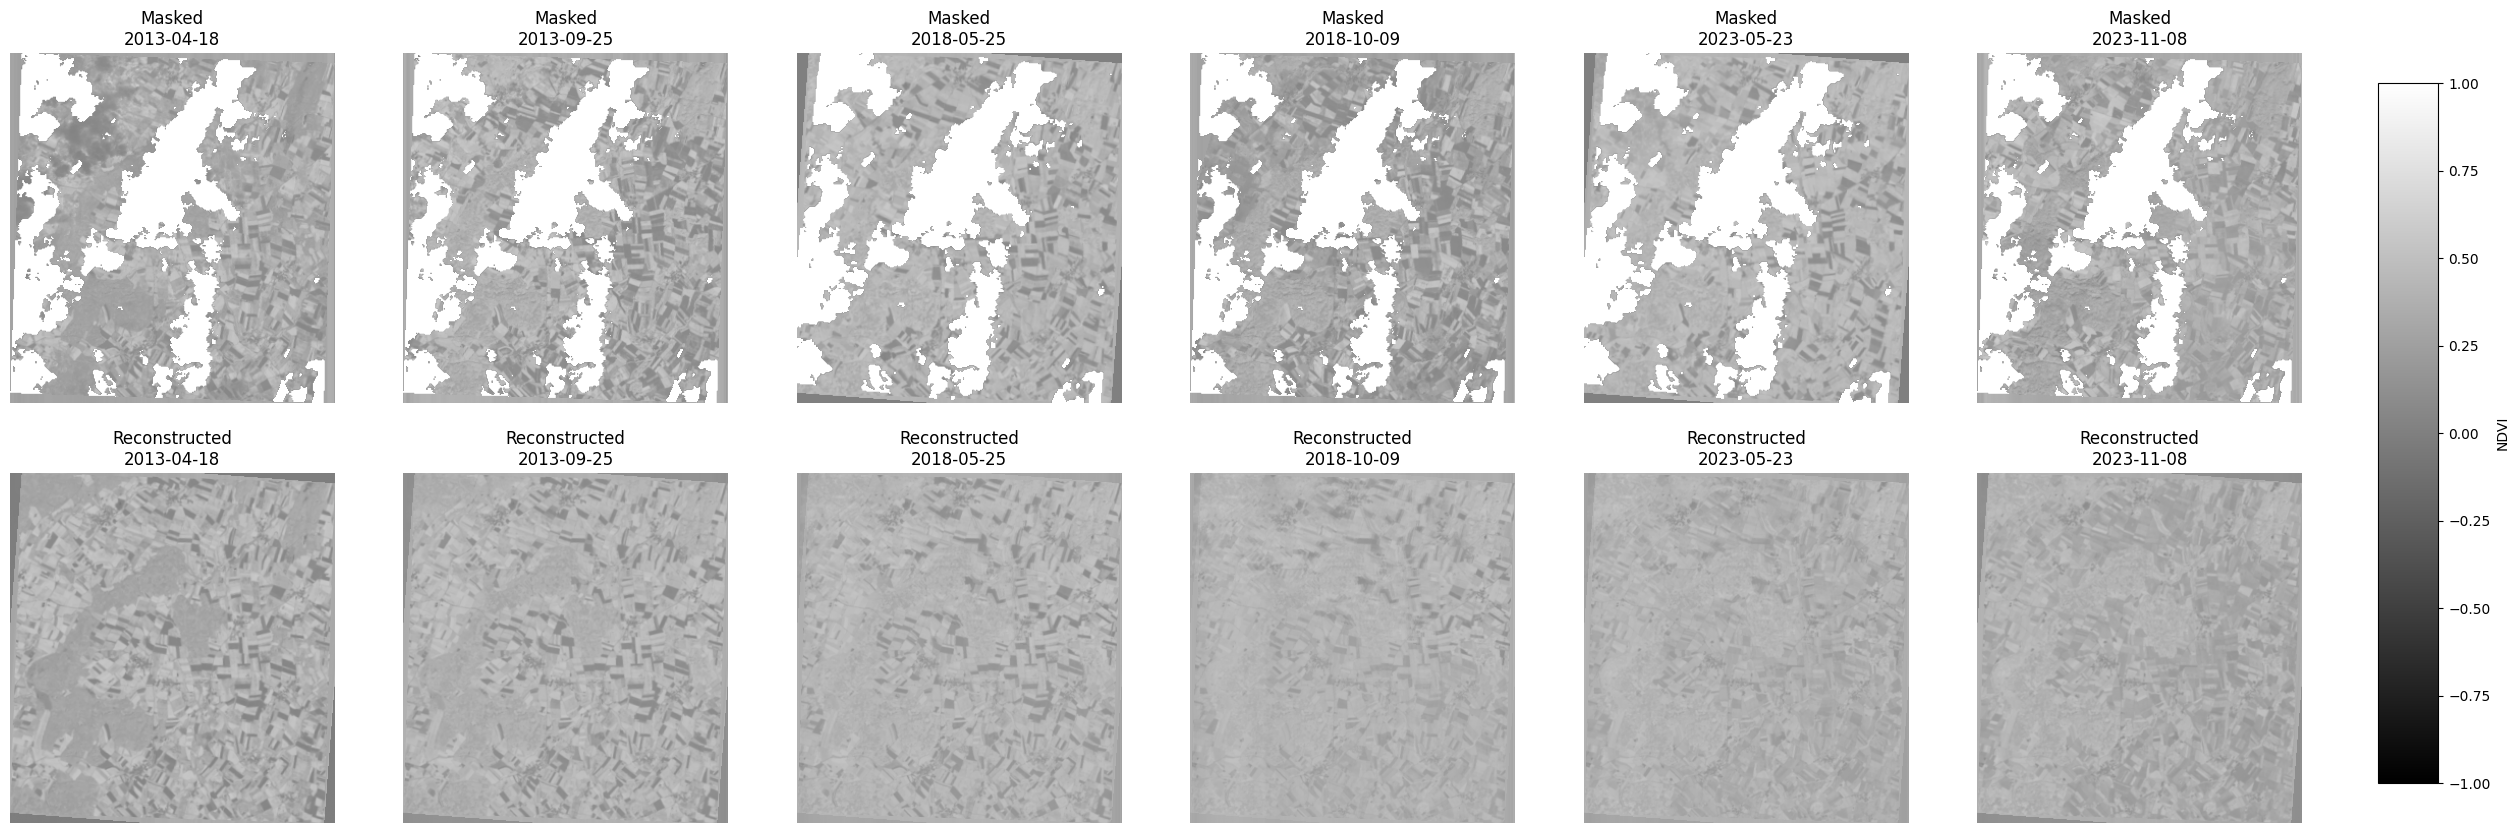

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Vérifie qu'on a bien le même nombre d'images masked et reconstruites
n_masked = landsat_masked_stack.shape[0]
if n_masked != len(masked_dates):
    print("⚠️ Incohérence entre masked stack et dates.")

fig, axs = plt.subplots(2, n_masked, figsize=(5 * n_masked, 10))

for k in range(n_masked):
    # Image masked (avec nuages/trous)
    im0 = axs[0, k].imshow(landsat_masked_stack[k], cmap="gray", vmin=-1, vmax=1)
    axs[0, k].set_title(f"Masked\n{masked_dates[k]}")
    axs[0, k].axis("off")

    # Image reconstruite (Whittaker)
    im1 = axs[1, k].imshow(smoothed[k], cmap="gray", vmin=-1, vmax=1)
    axs[1, k].set_title(f"Reconstructed\n{masked_dates[k]}")
    axs[1, k].axis("off")

# Ajouter une barre de couleur commune
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax, label="NDVI")

plt.subplots_adjust(wspace=0.1, hspace=0.2, right=0.9)
plt.show()

